In [63]:
# F1 Timing Data Analysis and Regression

## Step 1: Loading Libraries
import pandas as pd
import sqlite3
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import numpy as np

## Step 2: Data Loading
class DataLoader:
    def __init__(self, db_path):
        self.db_path = db_path

    def load_data(self):
        con = sqlite3.connect(self.db_path)
        tables = ["drivers", "fcyphases", "laps", "qualifyings", "races", "retirements", "starterfields"]
        self.dataframes = {table: pd.read_sql_query(f"SELECT * FROM {table}", con) for table in tables}
        con.close()
        return self.dataframes

## Step 3: Model Class for Data Cleaning and Regression
class F1Model:
    def __init__(self, season, driver_id, race_id, dataframes):
        self.driver_id = driver_id
        self.season=season
        self.race_id = race_id
        self.dfs = dataframes

    def clean_data(self):

        race_ids_season=list(self.dfs["races"][self.dfs["races"]["season"]==self.season]["id"])
        laps = self.dfs['laps']
        laps = laps[(laps["driver_id"] == self.driver_id)&(laps["race_id"].isin(race_ids_season))]
        starterfields = self.dfs['starterfields']
        starterfields = starterfields[(starterfields["driver_id"] == self.driver_id)&(starterfields["race_id"].isin(race_ids_season))]
        finished_races = starterfields[starterfields['status'] == 'F']
        laps = laps[laps['race_id'].isin(finished_races['race_id'])]

        # Exclude races for Brazil and Hungary due to rain as indicated in the document
        rainy_races = ["Budapest", "SaoPaulo"]
        races = self.dfs['races']
        rainy_race_ids = races[races['location'].isin(rainy_races)]["id"]
        laps = laps[~laps['race_id'].isin(rainy_race_ids)]

      # Exclude laps under safety car or virtual safety car
        fcyphases = self.dfs['fcyphases']
        fcyphases=fcyphases[fcyphases["race_id"].isin(race_ids_season)]
        for idx,row in fcyphases.iterrows():
            begin=row["startlap"]
            end=row["endlap"]
            laps = laps[~((laps['race_id']==row["race_id"]) & (laps["lapno"].between(begin,end)))]
        self.dfs['laps'] = laps

    def get_best_qualif_time(self):
        qualif_laps = self.dfs["qualifyings"]
        qualif_laps = qualif_laps[(qualif_laps["driver_id"] == self.driver_id)&(qualif_laps["race_id"].isin(self.dfs["laps"]["race_id"].unique()))]
        self.best_qualif_times = pd.DataFrame((
            qualif_laps[["race_id", "q1laptime", "q2laptime", "q3laptime"]]
            .groupby("race_id")
            .min()
            .min(axis=1)),columns=["best_qualif_time"]
        
        
        )

        self.dfs["laps"]=self.dfs["laps"].merge(self.best_qualif_times, on="race_id", how="left")
        print(self.best_qualif_times)
        print(self.dfs["laps"]["best_qualif_time"])


    def add_features(self):
        laps = self.dfs['laps']
        laps['fuelc'] = (
            100 - (100 / laps.groupby('race_id')['lapno'].transform('max')) * laps['lapno']
        )
        self.dfs['laps'] = laps

    def split_train_test(self):
        laps = self.dfs['laps']
        test_races = sorted(laps['race_id'].unique())[-5:]
        self.train_data = laps[~laps['race_id'].isin(test_races)]
        self.test_data = laps[laps['race_id'].isin(test_races)]

    def regression_analysis(self):
        formula = "laptime ~ best_qualif_time + fuelc + C(compound) + C(compound):tireage + C(compound):I(tireage**2)"
        self.model = smf.ols(formula=formula, data=self.train_data).fit()
        return self.model.summary()

    def analyze_regression_assumptions(self, model):
        # Residual Analysis
        residuals = model.resid
        fitted = model.fittedvalues

        # Linearity and Homoscedasticity
        plt.scatter(fitted, residuals, alpha=0.5)
        plt.axhline(y=0, color='red', linestyle='--')
        plt.xlabel('Fitted Values')
        plt.ylabel('Residuals')
        plt.title('Residuals vs Fitted Values')
        plt.show()

        # Normality of Residuals
        plt.hist(residuals, bins=30, alpha=0.7)
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title('Distribution of Residuals')
        plt.show()

        # Q-Q Plot for Normality
        import statsmodels.api as sm
        sm.qqplot(residuals, line='s')
        plt.title('Q-Q Plot of Residuals')
        plt.show()

        # Durbin-Watson Test for Autocorrelation
        dw_stat = sms.durbin_watson(residuals)
        print(f"Durbin-Watson statistic: {dw_stat}")

        # Variance Inflation Factor (VIF) for Multicollinearity
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        exog = model.model.exog
        vifs = [variance_inflation_factor(exog, i) for i in range(exog.shape[1])]
        print("Variance Inflation Factors:")
        for idx, vif in enumerate(vifs):
            print(f"Variable {model.model.exog_names[idx]}: VIF = {vif:.2f}")

        # Estimate residual variance (sigma^2)
        residual_variance = np.var(residuals, ddof=1)
        print(f"Variance des résidus (sigma^2): {residual_variance}")

    def regression_for_test_race_with_extended_train(self, race_id):
        # Filter data for the specific test race
        test_races = sorted(self.test_data['race_id'].unique())
        current_race_index = test_races.index(race_id)
        if current_race_index < 0:
            print(f"Race ID {race_id} not found in the test set.")
            return

        # Combine training data with previous test races
        previous_test_races = test_races[:current_race_index]
        extended_train_data = pd.concat(
            [self.train_data, self.test_data[self.test_data['race_id'].isin(previous_test_races)]],
            ignore_index=True
        )

        # Data for the current test race
        current_test_data = self.test_data[self.test_data['race_id'] == race_id]

        # Regression for the current test race
        formula = "laptime ~ best_qualif_time + fuelc + C(compound) + C(compound):tireage + C(compound):I(tireage**2)"
        model = smf.ols(formula=formula, data=extended_train_data).fit()
        print(model.summary())

        # Predict lap times for the current test race
        current_test_data['predicted_laptime'] = model.predict(current_test_data)

        # Plot predicted vs actual lap times for the race
        plt.figure(figsize=(10, 6))
        plt.plot(current_test_data['lapno'], current_test_data['laptime'], label='Actual Lap Time', marker='o')
        plt.plot(current_test_data['lapno'], current_test_data['predicted_laptime'], label='Predicted Lap Time', marker='x')
        plt.xlabel('Lap Number')
        plt.ylabel('Lap Time (s)')
        plt.title(f'Predicted vs Actual Lap Times for Race ID {race_id}')
        plt.legend()
        plt.grid()
        plt.show()

        # Analyze regression assumptions for the specific model
        self.analyze_regression_assumptions(model)

## Step 4: Main Workflow
# Load data
path = "F1_timingdata_2014_2019.sqlite"
data_loader = DataLoader(path)
dataframes = data_loader.load_data()

# Initialize model
model = F1Model(driver_id=1, season=2016,race_id=12, dataframes=dataframes)
model.clean_data()
model.get_best_qualif_time()

         best_qualif_time
race_id                  
39                 83.837
40                 89.493
41                    NaN
42                 95.820
44                 73.942
45                 72.812
46                103.526
47                 66.228
48                 89.243
50                 74.470
51                110.033
52                 81.135
53                103.288
55                 90.660
56                 94.999
57                 78.704
59                 98.755
0      83.837
1      83.837
2      83.837
3      83.837
4      83.837
        ...  
961    98.755
962    98.755
963    98.755
964    98.755
965    98.755
Name: best_qualif_time, Length: 966, dtype: float64


In [ ]:
model.get_best_qualif_time()
model.add_features()
model.split_train_test()

# Perform regression for a specific test race with extended training set
specific_race_id = model.test_data['race_id'].unique()[1]  # Choose the second race in the test set
model.regression_for_test_race_with_extended_train(specific_race_id)


In [23]:
dataframes["fcyphases"]["type"].unique()

array(['SC', 'VSC'], dtype=object)

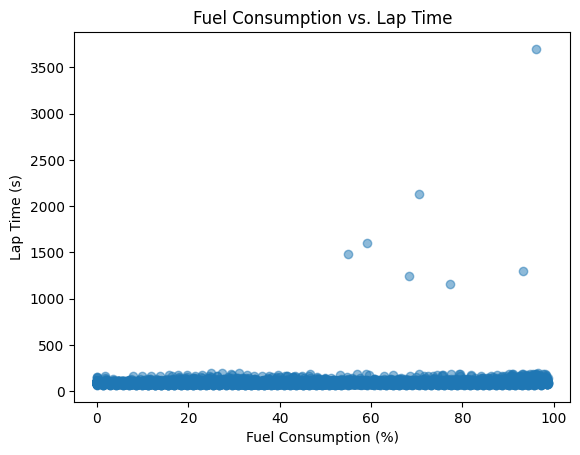

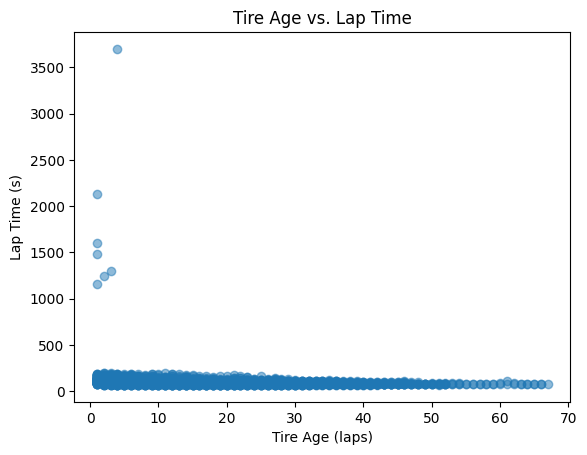

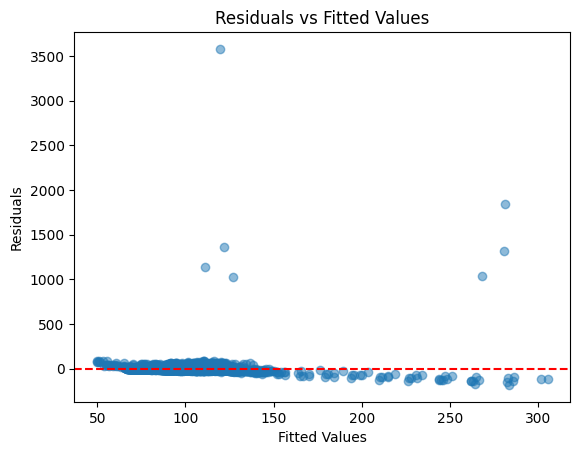

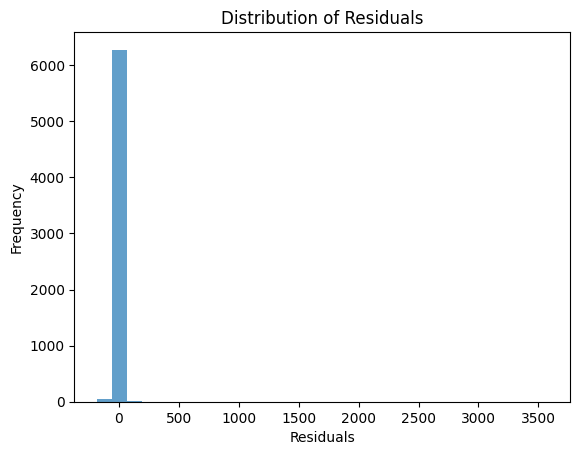

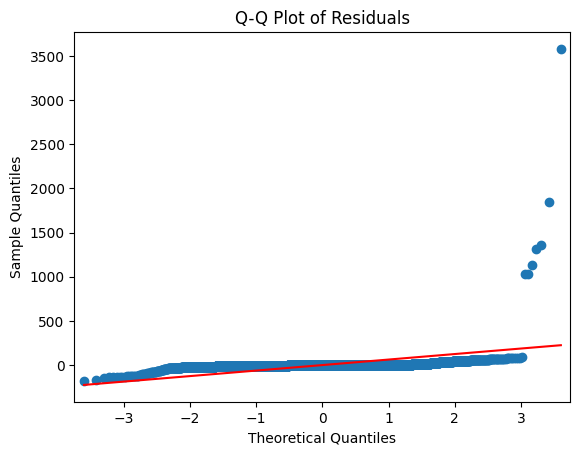

Durbin-Watson statistic: 1.9371354048558231
Variance Inflation Factors:
Variable Intercept: VIF = 312.29
Variable C(compound)[T.A2]: VIF = 35.28
Variable C(compound)[T.A3]: VIF = 57.37
Variable C(compound)[T.A4]: VIF = 53.91
Variable C(compound)[T.A5]: VIF = 29.62
Variable C(compound)[T.A6]: VIF = 19.39
Variable C(compound)[T.A7]: VIF = 17.00
Variable C(compound)[T.I]: VIF = 12.22
Variable C(compound)[T.W]: VIF = 10.18
Variable best_qualif_time: VIF = 1.15
Variable fuelc: VIF = 1.54
Variable C(compound)[A1]:tireage: VIF = 47.97
Variable C(compound)[A2]:tireage: VIF = 19.79
Variable C(compound)[A3]:tireage: VIF = 24.07
Variable C(compound)[A4]:tireage: VIF = 35.58
Variable C(compound)[A5]:tireage: VIF = 40.40
Variable C(compound)[A6]:tireage: VIF = 27.85
Variable C(compound)[A7]:tireage: VIF = 67.84
Variable C(compound)[I]:tireage: VIF = 39.04
Variable C(compound)[W]:tireage: VIF = 32.35
Variable C(compound)[A1]:I(tireage ** 2): VIF = 25.54
Variable C(compound)[A2]:I(tireage ** 2): VIF 

C:\Users\mateo\AppData\Local\Temp\ipykernel_35648\807529338.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model.test_data['predicted_laptime'] = model.model.predict(model.test_data)


In [7]:

# Visualizations and Model Evaluation
import matplotlib.pyplot as plt
plt.scatter(model.train_data['fuelc'], model.train_data['laptime'], alpha=0.5)
plt.xlabel('Fuel Consumption (%)')
plt.ylabel('Lap Time (s)')
plt.title('Fuel Consumption vs. Lap Time')
plt.show()

plt.scatter(model.train_data['tireage'], model.train_data['laptime'], alpha=0.5)
plt.xlabel('Tire Age (laps)')
plt.ylabel('Lap Time (s)')
plt.title('Tire Age vs. Lap Time')
plt.show()

# Analyze regression assumptions
model.analyze_regression_assumptions()

# Evaluate Test Data
model.test_data['predicted_laptime'] = model.model.predict(model.test_data)
print(model.test_data[['race_id', 'lapno', 'laptime', 'predicted_laptime']].head())